In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel, piecewise_function
from numpy import exp, sqrt, log
from scipy.interpolate import interp1d
import lets_be_rational.LetsBeRational as lbr
import time, sys
from montecarlo import MC_Analisys, MC
from matplotlib import ticker
from scipy.integrate import quad
from targetvol import time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy,TargetVolatilityEuler,Markowitz_solution,loss_function
from numpy.linalg import cholesky

In [2]:
def piecewise(x,T,a):
    mask = np.array([])
    mask = np.append(mask,(x>=0) & (x<T[0]))
    for i in range(1,len(T)):
        mask= np.append(mask,(x>=T[i-1]) & (x<T[i]))
    b = 0
    for i in range(len(T)):
        b = b+ a[i]*mask[i]
    return b

def step_function_integration1(f, time_grid, t_in, t_fin):
    y = np.array([])
    dt = np.array([])
    if t_fin in time_grid:
        time_grid = time_grid[np.where(time_grid<=t_fin)[0]]
    if t_in in time_grid:
        time_grid = time_grid[np.where(time_grid>=t_in)[0]]
    if t_in not in time_grid:
        time_grid = time_grid[np.where(time_grid>t_in)[0]]
        time_grid = np.insert(time_grid,0,t_in)
    if t_fin not in time_grid:
        time_grid = time_grid[np.where(time_grid<t_fin)[0]]
        time_grid = np.insert(time_grid,len(time_grid),t_fin)
    for i in range(len(time_grid)-1):
        y = np.append(y,f(time_grid[i]))
    dt = np.diff(time_grid)
    return np.sum(y*dt)

#### Test with a simple step function

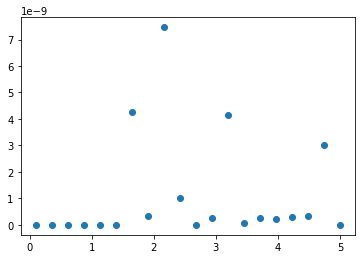

CPU times: user 1.8 s, sys: 12.3 ms, total: 1.81 s
Wall time: 1.8 s


In [3]:
%%time
T = np.array([1,2,3,4.5,6])
step = np.array([0.2,0.3,0.24,0.7,0.5])

f = lambda x: piecewise(x,T,step)
x = np.linspace(0.1,5,20)
my = np.array([])
theo = np.array([])
for i in x:
    my = np.append(my,step_function_integration1(f,T,0,i))
    theo = np.append(theo, quad(f,0,i,limit=500)[0])
    
plt.scatter(x,abs(my-theo))
plt.show()

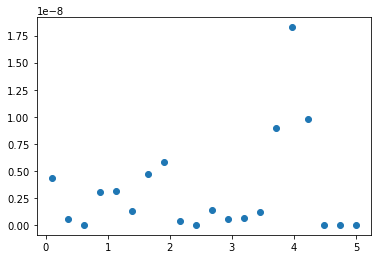

CPU times: user 2.13 s, sys: 82 ms, total: 2.21 s
Wall time: 2.1 s


In [4]:
%%time
T = np.array([1,2,3,4.5,6])
step = np.array([0.2,0.3,0.24,0.7,0.5])

f = lambda x: piecewise(x,T,step)
x = np.linspace(0.1,5,20)
my = np.array([])
theo = np.array([])
for i in x:
    my = np.append(my,step_function_integration1(f,T,i,6))
    theo = np.append(theo, quad(f,i,6,limit=500)[0])
    
plt.scatter(x,abs(my-theo))
plt.show()

#### Test with a complex step function

In [5]:
N_equity = 4                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120,97,133])            #spot price of the two assets
corr = np.array(([1,0.15,0.10,0.20],[0.15,1.,-0.05,0.18],[0.1,-0.05,1.,0.13],[0.20,0.18,0.13,1]))       #correlation matrix
minus = 1
"""Market Discount factors"""
r_t = np.array([1,1,1.9,1.2])/100            
T_discounts = np.array([0.,3,6.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([2,6,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = minus*np.array([0.32,0.35,0.33])/100  #market repo rates for equity 1


T_repo2 = np.array([3.,6.,T_max])
repo_rate2 = minus*np.array([0.21,0.2,0.25])/100

T_repo3 = np.array([2.,5.,T_max])
repo_rate3 = minus*np.array([0.1,0.17,0.199])/100

T_repo4 = np.array([5,T_max])
repo_rate4 = minus*np.array([0.2,0.24])/100


for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
sigma1 = np.array([20,20.6,22])/100
T_sigma1 = np.array([2,5.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

sigma2 = np.array([30,31,32.62])/100
T_sigma2 =  np.array([2.,6,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))  

sigma3 = np.array([25,23,22])/100
T_sigma3 = np.array([3,7.,T_max])
K3 = np.array([spot_price[2],200])
spot_vola3 = np.array((sigma3,sigma3))  

sigma4 = np.array([15,16,14])/100
T_sigma4 =  np.array([2,6.,T_max])
K4 = np.array([spot_price[3],200])
spot_vola4 = np.array((sigma4,sigma4))  

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))
        
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

zero interest rate time grid [ 0.  3.  6. 10.]
zero interest rate:  [0.01  0.01  0.019 0.012]
Forward repo time grid [ 2.  6. 10.]
Forward repo rate:  [0.0032  0.00365 0.003  ]
Forward volatility time grid:  [ 2.  5. 10.]
Forward volatility:  [0.2        0.20990474 0.23316089]
Forward repo time grid [ 3.  6. 10.]
Forward repo rate:  [0.0021  0.0019  0.00325]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.3        0.31488093 0.34909325]
Forward repo time grid [ 2.  5. 10.]
Forward repo rate:  [0.001      0.00216667 0.00228   ]
Forward volatility time grid:  [ 3.  7. 10.]
Forward volatility:  [0.25       0.21377558 0.19467922]
Forward repo time grid [ 5. 10.]
Forward repo rate:  [0.002  0.0028]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.15       0.16477257 0.1029563 ]


/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  # Remove the CWD from sys.path while we load stuff.


In [6]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)
alpha = Strategy()
alpha.Mark_strategy(mu=mu,nu=nu)
I_0 = np.sum(spot_price)
vol_target = 1/N_equity*sqrt(np.sum(nu(0.)@nu(0.).T))
print("Target volatility: ",vol_target)
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0   #ATM pricing
simulations = 1e6
kind = 1 #call option
print("Spot price ",I_0)
print("Dates ",dates)

Drift time grid: [ 2.  3.  5.  6. 10.]
Drift values: [[0.0032     0.0021     0.001      0.002     ]
 [0.00365    0.0021     0.00216667 0.002     ]
 [0.00365    0.0019     0.00216667 0.002     ]
 [0.00365    0.0019     0.00228    0.0028    ]
 [0.003      0.00325    0.00228    0.0028    ]]
Cholesky covariance-variance time grid: [ 2.  3.  5.  6.  7. 10.]
Cholesky covariance-variance matrix values: [[[ 0.2         0.20990474  0.20990474  0.23316089  0.23316089
    0.23316089]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.045       0.04723214  0.04723214  0.04723214  0.05236399
    0.05236399]
  [ 0.2966058   0.31131837  0.31131837  0.31131837  0.34514361
    0.34514361]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  


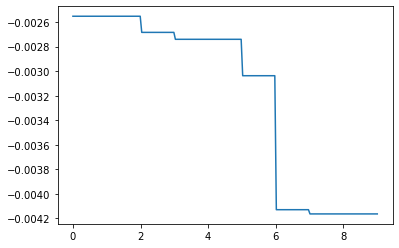

In [7]:
l = lambda x: vol_target*((alpha(x)@mu(x))/np.linalg.norm(alpha(x)@nu(x)))

y = np.linspace(0,9,200)
f = np.array([])
for i in y:
    f = np.append(f,l(i))
plt.plot(y,f)
plt.show()

In [8]:
%%time
print(alpha.T)
a = 0
b = 9.
my = step_function_integration1(l,alpha.T,a,b)
theo = quad(l,a,b, limit=500)[0]
print("my integration ",my)
print("quad integration",theo)
print("difference ",my - theo)

[ 2.  3.  5.  6.  7. 10.]
my integration  -0.02876151794278406
quad integration -0.02876151794278406
difference  0.0
CPU times: user 510 ms, sys: 33.8 ms, total: 543 ms
Wall time: 492 ms


[0.1        0.56842105 1.03684211 1.50526316 1.97368421 2.44210526
 2.91052632 3.37894737 3.84736842 4.31578947 4.78421053 5.25263158
 5.72105263 6.18947368 6.65789474 7.12631579 7.59473684 8.06315789
 8.53157895 9.        ]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.84637794e-10 1.18003335e-08 6.33153772e-11
 3.39341965e-09 1.72476997e-09 1.94520089e-09 1.12621508e-09
 4.11560218e-09 1.33711985e-09 1.50935215e-08 1.11997839e-09
 7.88437454e-10 4.92251392e-10 2.42575029e-09 0.00000000e+00]


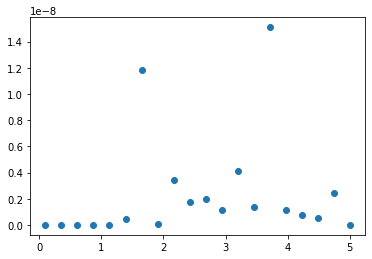

CPU times: user 9.2 s, sys: 70.3 ms, total: 9.27 s
Wall time: 9.19 s


In [9]:
%%time
y = np.linspace(0.1,9.,20)
print(y)
my = np.array([])
theo = np.array([])
for i in y:
    my = np.append(my,step_function_integration1(l,alpha.T,0,i))
    theo = np.append(theo, quad(l,0,i,limit=500)[0])
    
plt.scatter(x,abs(my-theo))
print(abs(my-theo))
plt.show()

In [10]:
my

array([-0.00025521, -0.00145068, -0.00264615, -0.00384161, -0.00503708,
       -0.00629072, -0.00754781, -0.0088263 , -0.01010983, -0.01139337,
       -0.0126769 , -0.01403542, -0.015458  , -0.01708752, -0.01902172,
       -0.02096027, -0.02291058, -0.02486089, -0.0268112 , -0.02876152])

In [11]:
theo

array([-0.00025521, -0.00145068, -0.00264615, -0.00384161, -0.00503708,
       -0.00629072, -0.00754783, -0.0088263 , -0.01010983, -0.01139337,
       -0.0126769 , -0.01403542, -0.015458  , -0.01708752, -0.0190217 ,
       -0.02096027, -0.02291058, -0.02486089, -0.0268112 , -0.02876152])